In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data import random_split, TensorDataset, DataLoader, Subset
import matplotlib.pyplot as plt
from pathlib import Path
import sys


# climb up to the repo root and add <repo>/src to Python's path
repo_root = Path().resolve().parents[0]   # parent of "notebooks"
sys.path.insert(0, str(repo_root / "src"))

from fisher_information.fim import FisherInformationMatrix
from models.image_classification_models import ConvModelMNIST
from models.train_test import *
#from prunning_methods.LTH import *
from fisher_information.NGD import *

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def build_loaders(data_dir: str, batch_size: int, device: torch.device, 
                  fim_size: int = 5000, seed: int = 42):
# CIFAR-10 stats
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
    
    
    train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean, std),
    ])
    
    
    test_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std),
    ])
    
    
    train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_tf)
    test_set = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=test_tf)

    num_classes = 10
    assert fim_size % num_classes == 0, \
        f"fim_size ({fim_size}) must be divisible by num_classes ({num_classes})"

    per_class = fim_size // num_classes

    targets = torch.tensor(train_set.targets)  # shape: [50000]
    g = torch.Generator().manual_seed(seed)
    
    indices_per_class = []
    for c in range(num_classes):
        class_idx = torch.nonzero(targets == c).view(-1)  # indices of samples of class c
        # shuffle indices for this class
        perm = class_idx[torch.randperm(len(class_idx), generator=g)]
        # take per_class samples
        indices_per_class.append(perm[:per_class])

    # concatenate all class indices and shuffle globally
    balanced_indices = torch.cat(indices_per_class)
    balanced_indices = balanced_indices[torch.randperm(len(balanced_indices), generator=g)]

    fim_subset = Subset(train_set, balanced_indices.tolist())
    
    train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
    )

    fim_loader = DataLoader(
    fim_subset,
    batch_size=1,
    shuffle=True
    )
    
    test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
    )
    
    return train_loader, fim_loader, test_loader

In [3]:
train_loader, fim_loader, test_loader = build_loaders('./data', 1028, device)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def resnet18_cifar(num_classes: int = 10) -> nn.Module:
    model = torchvision.models.resnet18(weights=None, num_classes=num_classes)
    # Replace the 7x7 stride-2 conv + maxpool with a 3x3 stride-1 conv and no pool
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    return model
#print(f"ResNet18 tem {sum([p.numel() for p in resnet18_cifar().parameters()])} parametros")

In [5]:
import random

def set_global_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_global_seed(42)

In [ ]:
fim_args = {"complete_fim": False, 
            "layers":  ['layer1.1.conv1.weight'], 
            "mask":  None, 
            "sampling_type":  'x_skip_y', 
            "sampling_frequency":  (9,81)
            }



LTH_args = {"model": resnet18_cifar(num_classes=10).to(device), 
            "criterion": nn.CrossEntropyLoss(), 
           "train_loader": train_loader,
            "test_loader": test_loader,
            "fim_loader": fim_loader,
            "fim_args": fim_args, 
            "lr" : 1e-3,
            "n_iterations":2, 
            "n_epochs":1, 
            "prunning_percentage":0.1, 
            "no_prunning_layers":None,
            "real_opt": 'singd', # 'adam' or 'singd'
            "structure": "diagonal", # "diag" or "dense"
            "verbose":True,
            "print_freq":10, 
            "use_scheduler":False, 
            "save_path":None
            }
           

In [ ]:
output_dict = train_LTH_adam_vs_ngd(**LTH_args)


=== LTH Iteration 1/2 ===
Current pruning percentage: 0.000
[HybridSINGD] SINGD-unsupported layers -> Adam fallback:
  - bn1
  - layer1.0.bn1
  - layer1.0.bn2
  - layer1.1.bn1
  - layer1.1.bn2
  - layer2.0.bn1
  - layer2.0.bn2
  - layer2.0.downsample.1
  - layer2.1.bn1
  - layer2.1.bn2
  - layer3.0.bn1
  - layer3.0.bn2
  - layer3.0.downsample.1
  - layer3.1.bn1
  - layer3.1.bn2
  - layer4.0.bn1
  - layer4.0.bn2
  - layer4.0.downsample.1
  - layer4.1.bn1
  - layer4.1.bn2


KeyboardInterrupt: 

: 

In [ ]:
output_dict.keys()

dict_keys(['mask_list', 'test_acc', 'fim_list', 'cos_sim_list', 'cos_dist_list'])

In [ ]:
fim.logdet_ratio

{'layer1.1.conv1.weight': 4142.185546875}

In [ ]:
for idx, fim in enumerate(output_dict["fim_list"]):
    print(f"{100 -(10*idx):.1f}% - Acc = {output_dict['test_acc'][idx]:.2f}, logdet_ratio = {fim.logdet_ratio['layer1.1.conv1.weight']:.2f}")

TypeError: unsupported format string passed to dict.__format__

100.0% - Acc = 0.22, logdet_ratio = 4142.19, logdet_ratio_per_dim = 1.12
90.0% - Acc = 0.22, logdet_ratio = 3501.87, logdet_ratio_per_dim = 1.05


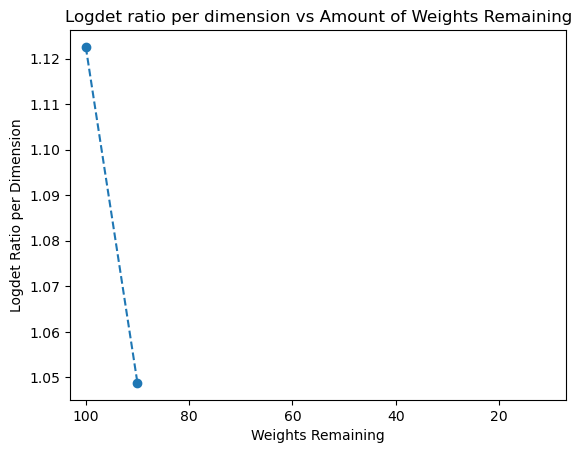

In [ ]:
logdet_per_dim_list = []
for idx, fim in enumerate(output_dict["fim_list"]):
    print(f"{100 -(10*idx):.1f}% - Acc = {output_dict['test_acc'][idx]:.2f}, logdet_ratio = {fim.logdet_ratio['layer1.1.conv1.weight']:.2f}, logdet_ratio_per_dim = {fim.logdet_ratio_per_dim['layer1.1.conv1.weight']:.2f}")
    logdet_per_dim_list.append(fim.logdet_ratio_per_dim['layer1.1.conv1.weight'])


plt.title('Logdet ratio per dimension vs Amount of Weights Remaining')
plt.xlabel('Weights Remaining')
plt.ylabel('Logdet Ratio per Dimension')
#plt.xticks((100, 80, 60, 40, 20, 10))
#plt.ylabel('Logdet Ratio per Dimension')
plt.scatter([100 - (10*i) for i in range(len(logdet_per_dim_list))], logdet_per_dim_list)
plt.plot([100 - (10*i) for i in range(len(logdet_per_dim_list))], logdet_per_dim_list, linestyle='--')
plt.xlim(103, 7)
plt.show()

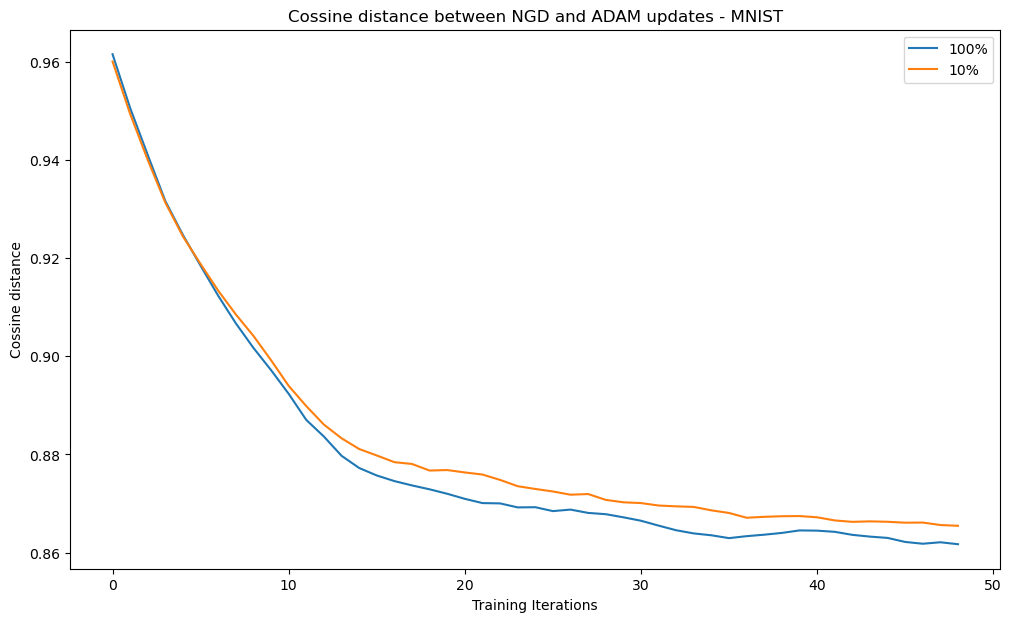

In [ ]:
fig, ax = plt.subplots(1,figsize=(12,7))
ax.plot(np.array(output_dict['cos_dist_list'][0]), label='100%')
ax.plot(np.array(output_dict['cos_dist_list'][-1]), label='10%')
plt.title('Cossine distance between NGD and ADAM updates - MNIST')
plt.xlabel('Training Iterations')
plt.ylabel('Cossine distance')
plt.legend()
plt.show()

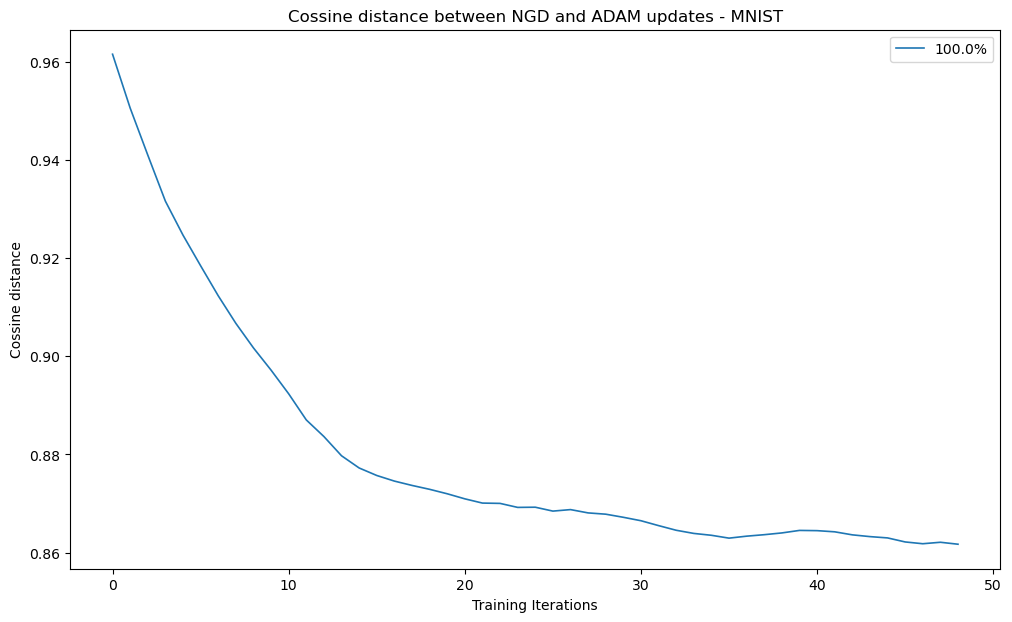

In [ ]:
fig, ax = plt.subplots(1,figsize=(12,7))
for i in range(0,len(output_dict['cos_dist_list']),2):
    ax.plot(np.array(output_dict['cos_dist_list'][i]), label=f'{100 -(10*i):.1f}%', linewidth=1.2)

#ax.plot(np.array(output_dict['cos_dist_list'][-1]), label=f'{10:.1f}%', linewidth=1.2)
plt.title('Cossine distance between NGD and ADAM updates - MNIST')
plt.xlabel('Training Iterations')
plt.ylabel('Cossine distance')
plt.legend()
plt.show()

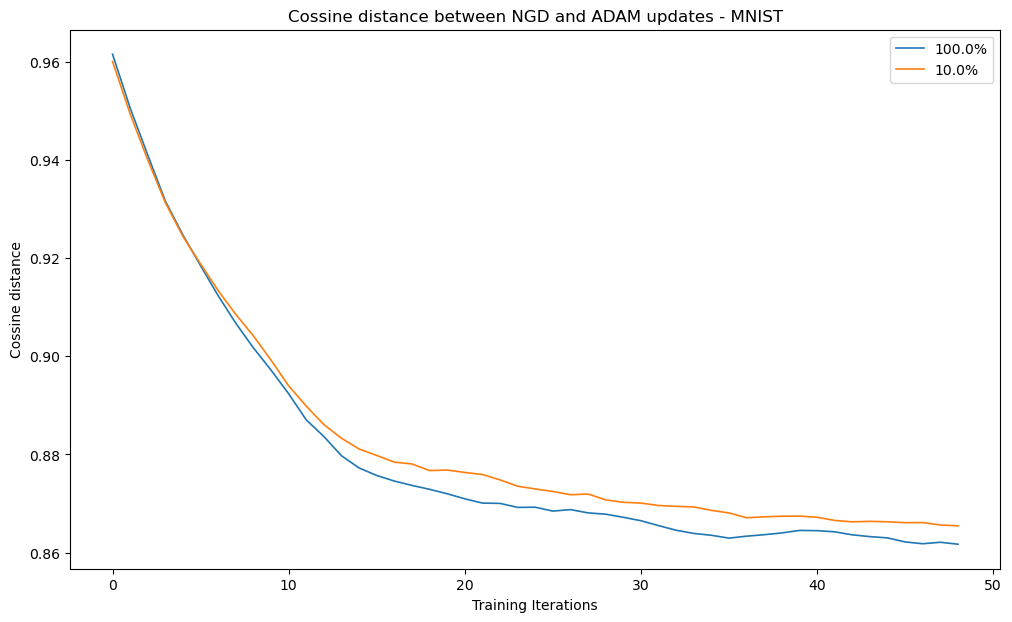

In [ ]:
fig, ax = plt.subplots(1,figsize=(12,7))
for i in range(0,len(output_dict['cos_dist_list']),2):
    ax.plot(np.array(output_dict['cos_dist_list'][i]), label=f'{100 -(10*i):.1f}%', linewidth=1.2)

ax.plot(np.array(output_dict['cos_dist_list'][-1]), label=f'{10:.1f}%', linewidth=1.2)
plt.title('Cossine distance between NGD and ADAM updates - MNIST')
plt.xlabel('Training Iterations')
plt.ylabel('Cossine distance')
plt.legend()
plt.show()

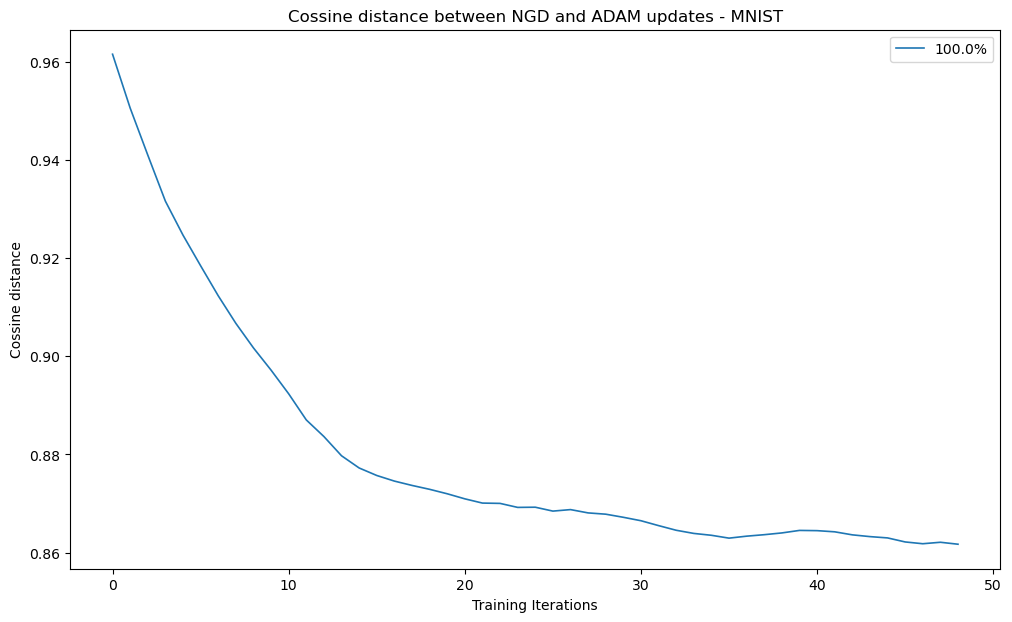

In [ ]:
fig, ax = plt.subplots(1,figsize=(12,7))
for i in range(0,len(output_dict['cos_dist_list']),3):
    ax.plot(np.array(output_dict['cos_dist_list'][i]), label=f'{100 -(10*i):.1f}%', linewidth=1.2)

#ax.plot(np.array(output_dict['cos_dist_list'][-1]), label=f'{10:.1f}%', linewidth=1.2)
plt.title('Cossine distance between NGD and ADAM updates - MNIST')
plt.xlabel('Training Iterations')
plt.ylabel('Cossine distance')
plt.legend()
plt.show()

In [ ]:
#torch.save(output_dict, "LTH_NGD_cifar10_output_dict_best_result.pth")

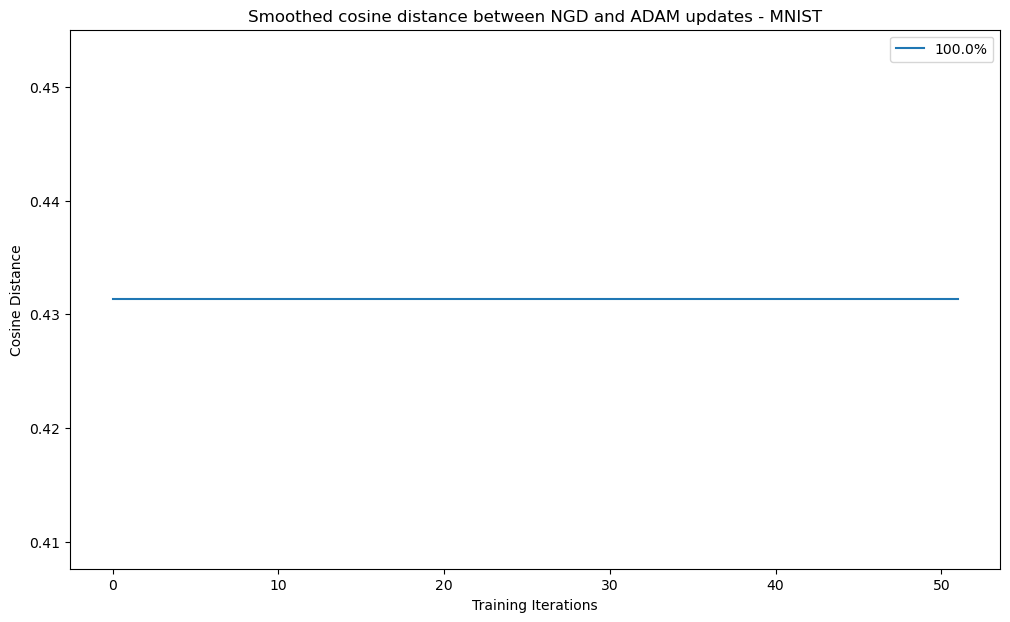

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# define smoothing function
def smooth_curve(x, window_size=50):
    window = np.ones(window_size) / window_size
    return np.convolve(x, window, mode='valid')

fig, ax = plt.subplots(1, figsize=(12, 7))

# loop through and plot smoothed data
for i in range(0, len(output_dict['cos_dist_list']), 2):
    data = np.array(output_dict['cos_dist_list'][i])
    smoothed = smooth_curve(data, window_size=100)  # try 50–200 for different smoothness
    ax.plot(smoothed, label=f'{100 - (10 * i):.1f}%', linewidth=1.5)

    

plt.title('Smoothed cosine distance between NGD and ADAM updates - MNIST')
plt.xlabel('Training Iterations')
plt.ylabel('Cosine Distance')
plt.legend()
plt.savefig('smoothed_cosine_distance_ngd_adam_mnist_1.png')
plt.show()


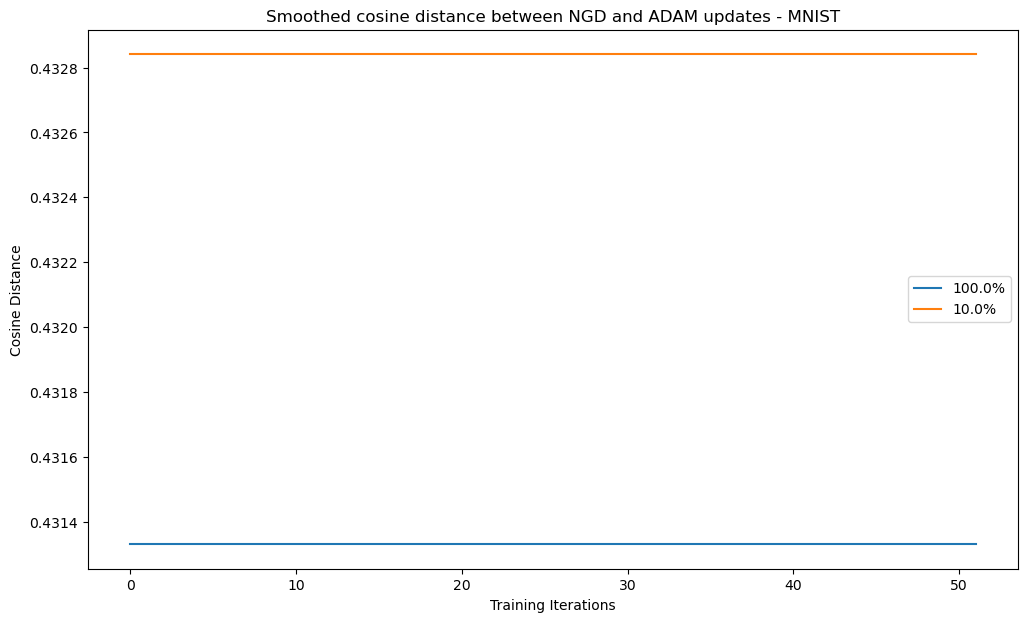

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 7))

# loop through and plot smoothed data
for i in range(0, len(output_dict['cos_dist_list']), 2):
    data = np.array(output_dict['cos_dist_list'][i])
    smoothed = smooth_curve(data, window_size=100)  # try 50–200 for different smoothness
    ax.plot(smoothed, label=f'{100 - (10 * i):.1f}%', linewidth=1.5)


data = np.array(output_dict['cos_dist_list'][-1])
smoothed = smooth_curve(data, window_size=100)  # try 50–200 for different smoothness
ax.plot(smoothed, label=f'{10:.1f}%', linewidth=1.5)

plt.title('Smoothed cosine distance between NGD and ADAM updates - MNIST')
plt.xlabel('Training Iterations')
plt.ylabel('Cosine Distance')
plt.legend()
plt.savefig('smoothed_cosine_distance_ngd_adam_mnist_2.png')
plt.show()
